This generates gblocks of designs from fasta files. The clusters can be specified in to 8 or 12 to fit a 96 well plate. 

Take difference between minimum and maximum of design based on name. Next, use kmeans to cluster designs into N-number of
cluster points. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from datetime import date
today = date.today()
# input and output file defined here:
# File name of output file
ofile = str(today)+"_DNA_sequence"
# inputfile 
# Needs to be DNA sequences - if it is amino acids
# one can convert it like this
'''
echo "argument 1: template DNA";
echo "argument 2: fastafile with designs";
echo "argument 3: Codons to use";
python /Users/pgreisen/pythonscripts/develop/insert_mutation_into_DNA_string/run_insert.py $1 $2 $3 

where the fastafile has to be named A21G_H56R_1


''' 
ifile = "2019-08-22_aa_sequences.fasta"

In [3]:
import pandas as pd
# parameters needed for the run
## bsaI sites for cloning
preseq = "GTCACGGTCTCA"
postseq = "CGAGACCAGTCA"
# range of basepair offset
bp_offset_nterm = 3
bp_offset_cterm = 3
bp_offset = 12
# envoke print statements
debug = 0
# variable parameter for the gene length
# g-blocks to synthetize
cutoff = [250,500,750,1000]
cluster_size = 12

In [4]:
# prices taken from here (Tubes): 
# https://www.idtdna.com/pages/products/genes-and-gene-fragments/gblocks-gene-fragments
idt_gblock = {
    250 : 71.10,
    500 : 71.10,
    750 : 80.10,
    1000 : 89.10,
    1250 : 143.10
}

In [5]:
def get_price(length):
    ln = int(length)
    if ln <= 250:
        return 71.10
    elif ln <= 500: 
        return 71.10
    elif ln <= 750:
        return 80.10
    elif ln <= 1000:
        return 89.10
    elif ln <= 1250:
        return 143.10
    elif ln <= 1500:
        return 179.1
    else:
        return "Error"

In [ ]:
def write_fasta_file_w_variants(df):
    lengt = []
    with open(ofile+".fasta",'w') as f:
        for varname, dnaseq, st, end in zip(df["VarName"],df["seq(DNA)"],df["start_cut_DNA"],df["end_cut_DNA"]):
            f.write(varname+"\n")
            lengt.append(len(preseq+dnaseq[st:end]+postseq))
            f.write(preseq+dnaseq[st:end]+postseq+"\n")
    return lengt

In [6]:
def read_fastafile(ifile):
    sequences = {}
    with open(ifile,'r') as f:
        for line in f:
            if(line[0] == ">"):
                tmp = line.split()
                ids = tmp[0]
                sequences[ids] = ""
            else:
                tmp = line.strip()
                sequences[ids] = sequences[ids] + tmp
    return sequences

In [7]:
def reassign_missing_variants(df):
    '''
    '''
    reassign_cluster = {}
    # sub-divide the rest into exciting cluster
    for i,j,k,c,l in zip(df.index, df["start_DNA_w_padding"], df["end_DNA_w_padding"], df["Clustered"],df["Size_of_gene"]):
        if(c == 0):
            for key in dict_w_start_stop:
                if( (j >= dict_w_start_stop[key][0]) & (k <= dict_w_start_stop[key][1])):
                    # add and sort such that we can add it to the
                    # shortest gene cluster
                    tmpkey = "index_"+str(i)
                    reassign_cluster[tmpkey] = (i,j,k,c,key,dict_w_start_stop[key][2])
    # sort dictionary
    listofTuples = sorted(reassign_cluster.items() ,  key=lambda x: x[-1] )
    r_c = dict(listofTuples)
    for key in reassign_cluster.keys():
        df.iloc[r_c[key][0], df.columns.get_loc("Clustered")] = 1
        df.iloc[r_c[key][0], df.columns.get_loc("Cluster_name")] = r_c[key][4]
        df.iloc[r_c[key][0], df.columns.get_loc("Size_of_gene")] = r_c[key][5]
    return df

In [8]:
sequences = read_fastafile(ifile)
df_sequences = pd.DataFrame.from_dict(sequences,orient='index',columns=['seq(DNA)'] )
df_sequences.reset_index(inplace=True)
df_sequences = df_sequences.rename(columns={'index':'VarName'})

In [9]:
def set_residue_numbers(seq_df):
    # initialize new columns
    seq_df["start_DNA"] = 0 
    seq_df["end_DNA"] = 0 
    # loop over keys in hash
    # Contain all the positions mutated
    residue_nr = []
    # contains residue numbers for each variant
    tmpresiduenr = {}
    for index,varname in zip(seq_df.index,seq_df["VarName"]):
        new_array = []
        nametmp_ = varname[1:].split("_")
        for j in nametmp_:
            new_array.append( int(j[1:-1] ) )
        mn = min(new_array)
        mx = max(new_array)
        # The -3 is due to counting from 0 and protein vs DNA
        seq_df.iloc[index,seq_df.columns.get_loc("start_DNA")] = 3*mn-3
        # 
        seq_df.iloc[index,seq_df.columns.get_loc("end_DNA")] = 3*mx
    return seq_df

In [10]:
df_sequences = set_residue_numbers(df_sequences)
df_sequences["start_DNA_w_padding"] = df_sequences["start_DNA"] - bp_offset
df_sequences["end_DNA_w_padding"] = df_sequences["end_DNA"] + bp_offset

In [11]:
df_sequences.sort_values(by=["start_DNA_w_padding","end_DNA_w_padding"],inplace=True)
df_sequences["length_DNA_w_padding"] = df_sequences["end_DNA_w_padding"] - df_sequences["start_DNA_w_padding"]

In [12]:
df_sequences["Clustered"] = 0
df_sequences["Cluster_name"] = ""
df_sequences["Size_of_gene"] = 0

In [13]:
def get_clusters(df,min_size_cluster,cutoff,gb="start_DNA_w_padding", parameter="length_DNA_w_padding"):
    # remove lengths greater than cutoff
    temp = df[(df[parameter] < cutoff) & (df["Clustered"] != 1) ]
    # count how many 
    tmp_= temp.groupby(gb).count().reset_index()
    # only clusters of certain size are investigated
    tmp_ = tmp_[tmp_["VarName"] >= min_size_cluster]
    return tmp_

def set_clusters(df,init_values, cutoff):
    for i,j,l,c in zip(df.index, df["start_DNA_w_padding"], df["length_DNA_w_padding"],df["Clustered"]):
        
        # bool value so you dont overwrite existing clusters
        if(c == 1):
            continue
        elif((j in init_values) & (l < cutoff)):
            df.iloc[i, df.columns.get_loc("Clustered")] = 1
            df.iloc[i, df.columns.get_loc("Cluster_name")] = "cluster_"+str(j)+"_"+str(j+cutoff)+"_"+str(cutoff)
            df.iloc[i, df.columns.get_loc("Size_of_gene")] = cutoff
        else:
            continue
    return df
#min_size_cluster = 3
df = df_sequences.copy()
df = df.reset_index()

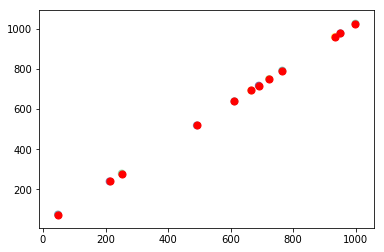

In [14]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
df_cluster = DataFrame(df,columns=['start_DNA_w_padding', 'end_DNA_w_padding'])
kmeans = KMeans(n_clusters=cluster_size).fit(df_cluster)
centroids = kmeans.cluster_centers_
plt.scatter(df_cluster['start_DNA_w_padding'], df_cluster['end_DNA_w_padding'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)

In [16]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = df.index.values
cluster_map['cluster'] = kmeans.labels_

In [17]:
# merge dataframes
df_kmeans = pd.merge(right=df, right_index=True, left=cluster_map, left_index=True)

In [18]:
df_kmeans.columns

Index(['data_index', 'cluster', 'index', 'VarName', 'seq(DNA)', 'start_DNA',
       'end_DNA', 'start_DNA_w_padding', 'end_DNA_w_padding',
       'length_DNA_w_padding', 'Clustered', 'Cluster_name', 'Size_of_gene'],
      dtype='object')

In [19]:
df_kmeans.drop(labels=['data_index', 'index',\
                       'start_DNA_w_padding', 'end_DNA_w_padding','length_DNA_w_padding',\
                       'Clustered','Size_of_gene','Cluster_name'], axis=1,inplace=True)

In [20]:
df_kmeans.columns

Index(['cluster', 'VarName', 'seq(DNA)', 'start_DNA', 'end_DNA'], dtype='object')

In [21]:
nr_clusters = list(set(kmeans.labels_))
df_kmeans['start_cut_DNA'] = 0
df_kmeans['end_cut_DNA'] = 0
df_kmeans['Size_of_gene'] = 0
df_kmeans['Cluster_name'] = ""

for cluster_ in nr_clusters:
    # get each cluster
    subcluster = df_kmeans[df_kmeans['cluster'] == cluster_]
    # print(subcluster)
    # start cut DNA
    mn_ = min(subcluster['start_DNA'])
    # end cut DNA
    mx_ = max(subcluster['end_DNA'])
    # size of gene
    length_ = mx_-mn_
    # cluster name
    clustername_ = "Cluster_"+str(mn_)+"_"+str(mx_)+"_cluster_nr_"+str(cluster_)
    for i in df_kmeans.index:
        if(df_kmeans.iloc[i,df_kmeans.columns.get_loc('cluster')] == cluster_):
            
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('start_cut_DNA')] = mn_ - bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('end_cut_DNA')] = mx_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Size_of_gene')] = length_ + bp_offset
            df_kmeans.iloc[i,df_kmeans.columns.get_loc('Cluster_name')]= clustername_

In [22]:
df_kmeans.head()

,cluster,VarName,seq(DNA),start_DNA,end_DNA,start_cut_DNA,end_cut_DNA,Size_of_gene,Cluster_name
0,4,>N21I,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,60,63,48,75,15,Cluster_60_63_cluster_nr_4
1,1,>V76H,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,225,228,213,240,15,Cluster_225_228_cluster_nr_1
2,8,>S89F,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,264,267,252,279,15,Cluster_264_267_cluster_nr_8
3,3,>N169K,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,504,507,492,519,15,Cluster_504_507_cluster_nr_3
4,5,>E209A,GCGAACCCGCGTGAAAACTTCCTGAAATGCTTCTCTCAGTACATCC...,624,627,612,639,15,Cluster_624_627_cluster_nr_5


In [23]:
# Calculate price
df_kmeans["IDT_price"] = df_kmeans["Size_of_gene"].apply(get_price)
print("The price of the order is: ",df_kmeans["IDT_price"].sum())
print("Number of unique cluster: ", len(df_kmeans["Cluster_name"].unique()))
tmp = df_kmeans.groupby("Cluster_name").count()
print("Size of the different clusters: ",tmp["VarName"] )

The price of the order is:  853.2
Number of unique cluster:  12
Size of the different clusters:  Cluster_name
Cluster_1011_1014_cluster_nr_7    1
Cluster_225_228_cluster_nr_1      1
Cluster_264_267_cluster_nr_8      1
Cluster_504_507_cluster_nr_3      1
Cluster_60_63_cluster_nr_4        1
Cluster_624_627_cluster_nr_5      1
Cluster_678_681_cluster_nr_10     1
Cluster_702_705_cluster_nr_0      1
Cluster_735_738_cluster_nr_9      1
Cluster_777_780_cluster_nr_6      1
Cluster_945_948_cluster_nr_11     1
Cluster_963_966_cluster_nr_2      1
Name: VarName, dtype: int64


In [24]:
df_kmeans.to_excel(ofile+".xlsx")

In [25]:
a = write_fasta_file_w_variants(df_kmeans)